In [1]:
from collections import defaultdict
import gymnasium as gym
import numpy as np


class BlackjackAgent:
    def __init__(
        self,
        env: gym.Env,
        learning_rate: float,
        initial_epsilon: float,
        epsilon_decay: float,
        final_epsilon: float,
        discount_factor: float = 0.95,
    ):
        """Initialize a SARSA agent.

        Args:
            env: The training environment
            learning_rate: How quickly to update Q-values (0-1)
            initial_epsilon: Starting exploration rate (usually 1.0)
            epsilon_decay: How much to reduce epsilon each episode
            final_epsilon: Minimum exploration rate (usually 0.1)
            discount_factor: How much to value future rewards (0-1)
        """
        self.env = env

        # Q-table: maps (state, action) to expected reward
        # defaultdict automatically creates entries with zeros for new states
        self.q_values = defaultdict(lambda: np.zeros(env.action_space.n))

        self.lr = learning_rate
        self.discount_factor = discount_factor  # How much we care about future rewards

        # Exploration parameters
        self.epsilon = initial_epsilon
        self.epsilon_decay = epsilon_decay
        self.final_epsilon = final_epsilon

        # Track learning progress
        self.training_error = []

    def get_action(self, obs: tuple[int, int, bool]) -> int:
        """Choose an action using epsilon-greedy strategy.

        Returns:
            action: 0 (stand) or 1 (hit)
        """
        # With probability epsilon: explore (random action)
        if np.random.random() < self.epsilon:
            return self.env.action_space.sample()

        # With probability (1-epsilon): exploit (best known action)
        else:
            return int(np.argmax(self.q_values[obs]))

    def update(
        self,
        obs: tuple[int, int, bool],
        action: int,
        reward: float,
        terminated: bool,
        next_obs: tuple[int, int, bool],
        next_action: int,
    ):
        """Update Q-value based on experience.

        This is the heart of SARSA: learn from (state, action, reward, next_state, next_action)
        """
        # Use next_action chosen from the current policy on-policy
        # (Zero if episode terminated - no future rewards possible)
        future_q_value = (not terminated) * self.q_values[next_obs][next_action]

        # What should the Q-value be? (Bellman equation)
        target = reward + self.discount_factor * future_q_value

        # How wrong was our current estimate?
        temporal_difference = target - self.q_values[obs][action]

        # Update our estimate in the direction of the error
        # Learning rate controls how big steps we take
        self.q_values[obs][action] = (
            self.q_values[obs][action] + self.lr * temporal_difference
        )

        # Track learning progress (useful for debugging)
        self.training_error.append(temporal_difference)

    def decay_epsilon(self):
        """Reduce exploration rate after each episode."""
        self.epsilon = max(self.final_epsilon, self.epsilon - self.epsilon_decay)

In [2]:
# Training hyperparameters
learning_rate = 0.01        # How fast to learn (higher = faster but less stable)
n_episodes = 5_000_000        # Number of hands to practice
start_epsilon = 1.0         # Start with 100% random actions
epsilon_decay = start_epsilon / (n_episodes / 2)  # Reduce exploration over time
final_epsilon = 0.1         # Always keep some exploration

# Create environment and agent
env = gym.make("Blackjack-v1", sab=False)
env = gym.wrappers.RecordEpisodeStatistics(env, buffer_length=n_episodes)

agent = BlackjackAgent(
    env=env,
    learning_rate=learning_rate,
    initial_epsilon=start_epsilon,
    epsilon_decay=epsilon_decay,
    final_epsilon=final_epsilon,
)

In [3]:
from tqdm.notebook import tqdm  # Progress bar

for episode in tqdm(range(n_episodes)):
    # Start a new hand
    obs, info = env.reset()
    # Agent chooses action (initially random, gradually more intelligent)
    action = agent.get_action(obs)
    done = False

    # Play one complete hand
    while not done:
        # Take action and observe result
        next_obs, reward, terminated, truncated, info = env.step(action)
        done = terminated or truncated

        next_action = agent.get_action(next_obs) if not done else 0

        # Learn from this experience
        agent.update(obs, action, reward, terminated, next_obs, next_action)

        obs, action = next_obs, next_action

    # Reduce exploration rate (agent becomes less random over time)
    agent.decay_epsilon()

100%|██████████| 5000000/5000000 [04:00<00:00, 20755.79it/s]


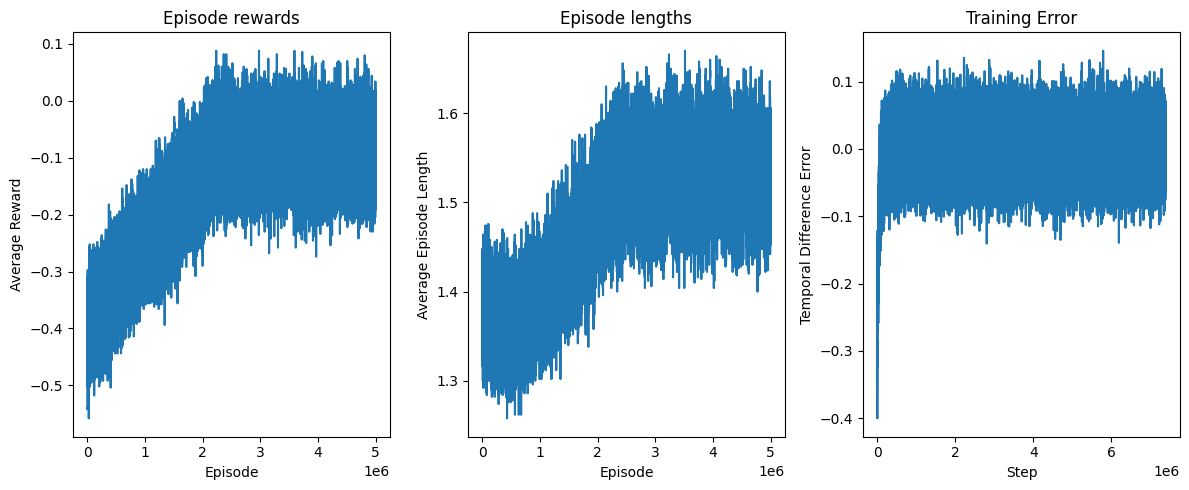

In [4]:
from matplotlib import pyplot as plt

def get_moving_avgs(arr, window, convolution_mode):
    """Compute moving average to smooth noisy data."""
    return np.convolve(
        np.array(arr).flatten(),
        np.ones(window),
        mode=convolution_mode
    ) / window

# Smooth over a 500-episode window
rolling_length = 500
fig, axs = plt.subplots(ncols=3, figsize=(12, 5))

# Episode rewards (win/loss performance)
axs[0].set_title("Episode rewards")
reward_moving_average = get_moving_avgs(
    env.return_queue,
    rolling_length,
    "valid"
)
axs[0].plot(range(len(reward_moving_average)), reward_moving_average)
axs[0].set_ylabel("Average Reward")
axs[0].set_xlabel("Episode")

# Episode lengths (how many actions per hand)
axs[1].set_title("Episode lengths")
length_moving_average = get_moving_avgs(
    env.length_queue,
    rolling_length,
    "valid"
)
axs[1].plot(range(len(length_moving_average)), length_moving_average)
axs[1].set_ylabel("Average Episode Length")
axs[1].set_xlabel("Episode")

# Training error (how much we're still learning)
axs[2].set_title("Training Error")
training_error_moving_average = get_moving_avgs(
    agent.training_error,
    rolling_length,
    "same"
)
axs[2].plot(range(len(training_error_moving_average)), training_error_moving_average)
axs[2].set_ylabel("Temporal Difference Error")
axs[2].set_xlabel("Step")

plt.tight_layout()
# Save as PNG into your Drive folder
plt.savefig('SARSA_plot.png', dpi=300, bbox_inches='tight')
plt.show()

In [5]:
# Test the trained agent
def test_agent(agent, env, num_episodes=1000):
    """Test agent performance without learning or exploration."""
    total_rewards = []

    # Temporarily disable exploration for testing
    old_epsilon = agent.epsilon
    agent.epsilon = 0.0  # Pure exploitation

    for _ in range(num_episodes):
        obs, info = env.reset()
        episode_reward = 0
        done = False

        while not done:
            action = agent.get_action(obs)
            obs, reward, terminated, truncated, info = env.step(action)
            episode_reward += reward
            done = terminated or truncated

        total_rewards.append(episode_reward)

    # Restore original epsilon
    agent.epsilon = old_epsilon

    win_rate = np.mean(np.array(total_rewards) > 0)
    average_reward = np.mean(total_rewards)

    print(f"Test Results over {num_episodes} episodes:")
    print(f"Win Rate: {win_rate:.1%}")
    print(f"Average Reward: {average_reward:.3f}")
    print(f"Standard Deviation: {np.std(total_rewards):.3f}")

# Test your agent
test_agent(agent, env, num_episodes=50000)

Test Results over 50000 episodes:
Win Rate: 42.8%
Average Reward: -0.051
Standard Deviation: 0.951


In [14]:
# === Visualize optimal actions (greedy policy) for vanilla Blackjack ===
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap, BoundaryNorm


def _dealer_tick_labels():
    # Show Ace after 10
    return [str(i) for i in range(2, 11)] + ['A']


def plot_optimal_policy(agent):
    """Plot the greedy action (argmax Q) for each (player_sum, dealer_upcard, usable_ace).
    Two heatmaps are shown: UA=0 and UA=1. States unseen during training are left blank (NaN).
    Uses an axis-aligned extent so ticks line up with cell centers, crops UA=1 to reachable sums (12..21),
    and orders dealer upcards as 2..10, A (Ace last).
    """
    # Plotting x-positions are fixed at column centers 1..10
    x_pos = list(range(1, 11))
    x_labels = _dealer_tick_labels()              # ['2',..,'10','A']
    dv_order = list(range(2, 11)) + [1]           # map columns to dealer values (Ace last)

    # Reachable player sums: without usable ace ~4..21, with usable ace ~12..21
    y0_vals = list(range(4, 22))
    y1_vals = list(range(12, 22))

    def build_matrix(ua: int, y_vals: list[int]):
        M = np.full((len(y_vals), len(x_pos)), np.nan, dtype=float)
        for iy, ps in enumerate(y_vals):
            for ix, dv in enumerate(dv_order):
                obs = (ps, dv, ua)
                if obs in agent.q_values:
                    q = np.asarray(agent.q_values[obs], dtype=float)
                    if q.size >= 2:
                        M[iy, ix] = int(np.argmax(q[:2]))  # 0=stand, 1=hit
        return M

    M0 = build_matrix(0, y0_vals)
    M1 = build_matrix(1, y1_vals)

    # Discrete 2-color map with explicit boundaries
    cmap = ListedColormap(['#1f77b4', '#17becf'])  # Stand, Hit
    norm = BoundaryNorm([-0.5, 0.5, 1.5], cmap.N)

    fig, axs = plt.subplots(1, 2, figsize=(12, 5), sharex=False, sharey=False)

    def draw(ax, M, y_vals, title):
        im = ax.imshow(
            M,
            origin='lower',
            aspect='auto',
            extent=[0.5, 10.5, min(y_vals) - 0.5, max(y_vals) + 0.5],  # align ticks with cell centers
            cmap=cmap,
            norm=norm,
        )
        ax.set_title(title)
        ax.set_xlabel('Dealer upcard')
        ax.set_xticks(x_pos, labels=x_labels)
        ax.set_ylabel('Player sum')
        ax.set_yticks(y_vals)
        ax.grid(which='both', color='k', linestyle=':', linewidth=0.3, alpha=0.25)
        return im

    im0 = draw(axs[0], M0, y0_vals, 'Usable Ace=0')
    im1 = draw(axs[1], M1, y1_vals, 'Usable Ace=1')

    cbar = fig.colorbar(
        plt.cm.ScalarMappable(cmap=cmap, norm=norm),
        ax=axs.ravel().tolist(),
        fraction=0.046,
        pad=0.04,
        ticks=[0, 1],
    )
    cbar.ax.set_yticklabels(['Stand (0)', 'Hit (1)'])
    fig.suptitle('Greedy policy (argmax Q) by state')
    plt.tight_layout()
    plt.show()


def plot_q_delta(agent, vmin=None, vmax=None):
    """Plot Q_hit - Q_stand for each state to visualize action advantage (red=hit, blue=stand).
    Crops UA=1 to reachable sums (12..21), aligns ticks with cell centers, and orders dealer upcards 2..10, A.
    """
    x_pos = list(range(1, 11))
    x_labels = _dealer_tick_labels()
    dv_order = list(range(2, 11)) + [1]
    y0_vals = list(range(4, 22))
    y1_vals = list(range(12, 22))

    def build_matrix(ua: int, y_vals: list[int]):
        M = np.full((len(y_vals), len(x_pos)), np.nan, dtype=float)
        for iy, ps in enumerate(y_vals):
            for ix, dv in enumerate(dv_order):
                obs = (ps, dv, ua)
                if obs in agent.q_values:
                    q = np.asarray(agent.q_values[obs], dtype=float)
                    if q.size >= 2:
                        M[iy, ix] = q[1] - q[0]
        return M

    D0 = build_matrix(0, y0_vals)
    D1 = build_matrix(1, y1_vals)

    fig, axs = plt.subplots(1, 2, figsize=(12, 5), sharex=False, sharey=False)

    def draw(ax, M, y_vals, title):
        im = ax.imshow(
            M,
            origin='lower',
            aspect='auto',
            extent=[0.5, 10.5, min(y_vals) - 0.5, max(y_vals) + 0.5],
            cmap='coolwarm',
            vmin=vmin,
            vmax=vmax,
        )
        ax.set_title(title)
        ax.set_xlabel('Dealer upcard')
        ax.set_xticks(x_pos, labels=x_labels)
        ax.set_ylabel('Player sum')
        ax.set_yticks(y_vals)
        ax.grid(which='both', color='k', linestyle=':', linewidth=0.3, alpha=0.25)
        fig.colorbar(im, ax=ax, fraction=0.046, pad=0.04)

    draw(axs[0], D0, y0_vals, 'UA=0 (Q_hit - Q_stand)')
    draw(axs[1], D1, y1_vals, 'UA=1 (Q_hit - Q_stand)')

    fig.suptitle('Action advantage by state')
    plt.tight_layout()
    plt.show()

C:\Users\limyi\AppData\Local\Temp\ipykernel_4356\1330953126.py:76: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


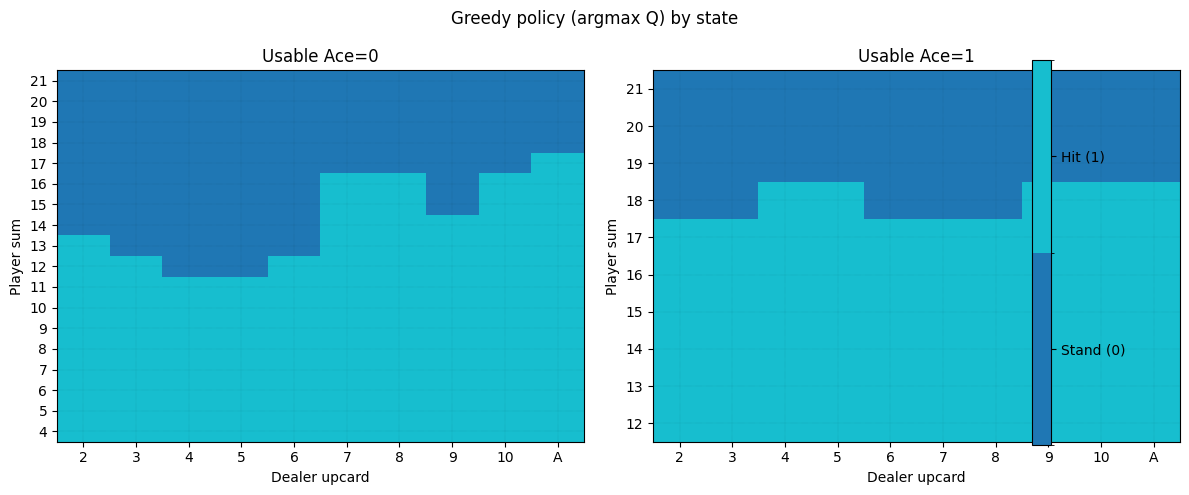

In [15]:
# Call the visualization (safe-guarded)
try:
    _ = agent  # ensure defined
    plot_optimal_policy(agent)
    # Optionally also show the action advantage maps:
    # plot_q_delta(agent)
except NameError:
    print("Agent is not defined. Train or load an agent, then rerun this cell.")
except Exception as e:
    print("Could not plot policy. Ensure the agent is trained and q_values are populated.")
    print(e)